In [ ]:
# conection to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unziping dataset
!unzip /content/drive/MyDrive/data/Animals-10.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP

In [ ]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
from PIL import Image

import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision.io import read_image

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [ ]:
# counting number of images in classes
path = '/content/dataset/raw-img'
classes = os.listdir(path)

class_names = {}
for class_name in classes:
  class_names[class_name] = len(os.listdir(os.path.join(path, class_name)))

class_names

{'scoiattolo': 1862,
 'elefante': 1446,
 'gallina': 3098,
 'cane': 4863,
 'pecora': 1820,
 'farfalla': 2112,
 'mucca': 1866,
 'gatto': 1668,
 'cavallo': 2623,
 'ragno': 4821}

In [ ]:
# sorting classes distribution for visualization
class_names_sorted = dict(reversed(sorted(class_names.items(), key=lambda item: item[1])))
class_names_sorted

{'cane': 4863,
 'ragno': 4821,
 'gallina': 3098,
 'cavallo': 2623,
 'farfalla': 2112,
 'mucca': 1866,
 'scoiattolo': 1862,
 'pecora': 1820,
 'gatto': 1668,
 'elefante': 1446}

[Text(0, 0, 'scoiattolo'),
 Text(1, 0, 'elefante'),
 Text(2, 0, 'gallina'),
 Text(3, 0, 'cane'),
 Text(4, 0, 'pecora'),
 Text(5, 0, 'farfalla'),
 Text(6, 0, 'mucca'),
 Text(7, 0, 'gatto'),
 Text(8, 0, 'cavallo'),
 Text(9, 0, 'ragno')]

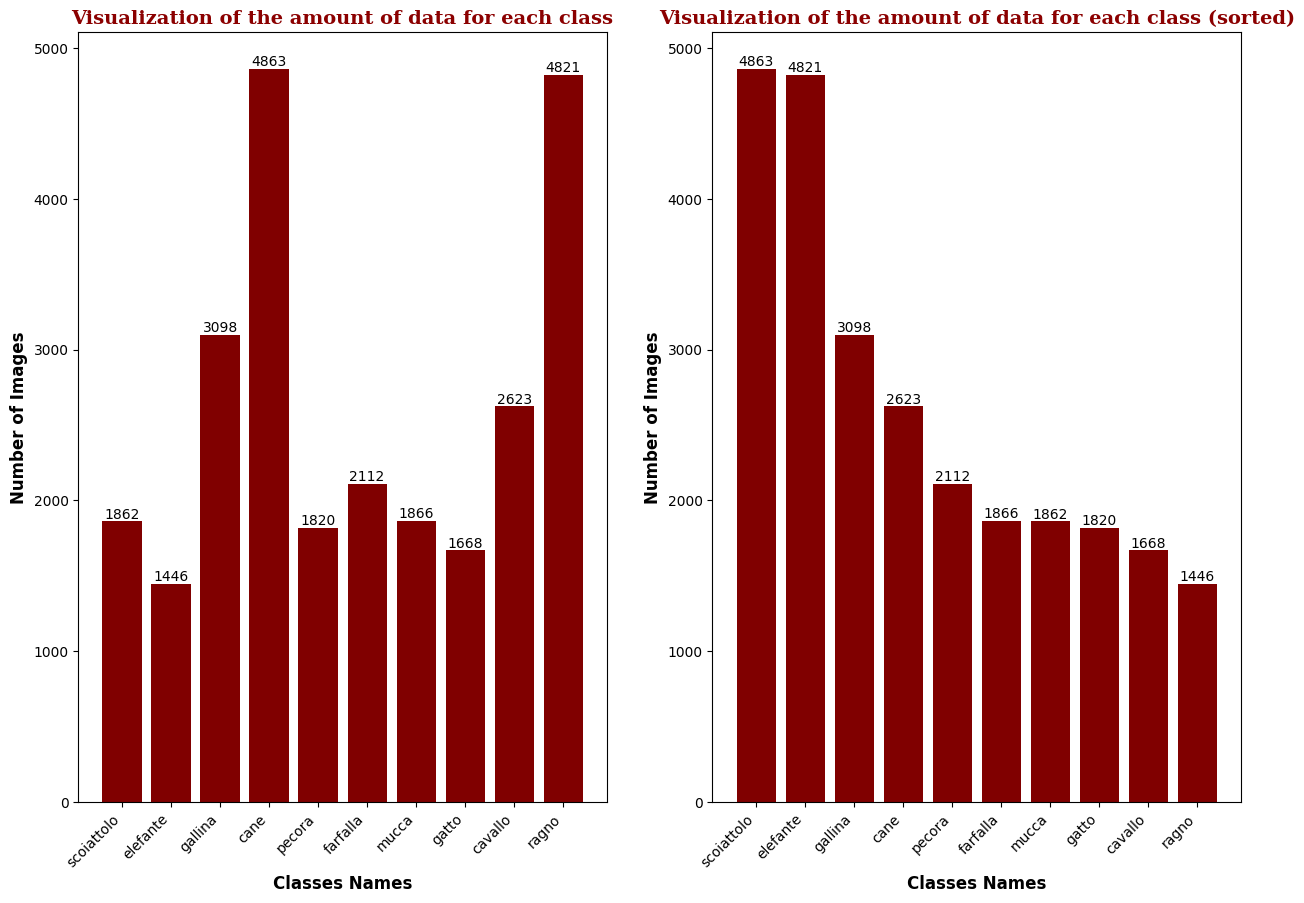

In [ ]:
labels = list(class_names.keys())
values = list(class_names.values())
labels_sorted = list(class_names_sorted.keys())
values_sorted = list(class_names_sorted.values())

figure, axis = plt.subplots(1, 2, figsize=(15,10))

font_for_title = {
    'family': 'serif',
    'color':  'darkred',
    'weight': 'bold',
    'size': 14,
    }

font_for_labels = {
    'family': 'sans serif',
    'color':  'black',
    'weight': 'bold',
    'size': 12,
    }

bars = axis[0].bar(labels, values, color='maroon')
for bar in bars:
    height = bar.get_height()
    axis[0].text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=10)

axis[0].set_title('Visualization of the amount of data for each class', fontdict=font_for_title)
axis[0].set_xlabel('Classes Names', fontdict=font_for_labels)
axis[0].set_ylabel('Number of Images', fontdict=font_for_labels)
axis[0].set_xticks(axis[0].get_xticks())
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45, ha='right')

bars = axis[1].bar(labels_sorted, values_sorted, color='maroon')
for bar in bars:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=10)

axis[1].set_title('Visualization of the amount of data for each class (sorted)', fontdict=font_for_title)
axis[1].set_xlabel('Classes Names', fontdict=font_for_labels)
axis[1].set_ylabel('Number of Images', fontdict=font_for_labels)
axis[1].set_xticks(axis[0].get_xticks())
axis[1].set_xticklabels(axis[0].get_xticklabels(), rotation=45, ha='right')

In [ ]:
# conversion to tensors
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),                                   # setting one size for all images
    transforms.ToTensor(),                                           # converting to tensors
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalization # with normalization images have TOO MUCH contrast
])

In [ ]:
# conversion to tensors
transform = transforms.Compose([
    transforms.Resize((256, 256)),        # setting one size for all images
    transforms.RandomHorizontalFlip(),    # random horiz flip of images
    transforms.RandomRotation(15),        # random rotation
    transforms.ToTensor(),                # converting to tensors
])

In [ ]:
# loading dataset
data = torchvision.datasets.ImageFolder(root='/content/dataset/raw-img', transform=None)

In [ ]:
# looking for corrupted images
corrupted_images = []
for image in data.imgs:
  img_path = image[0]
  try:
      img = Image.open(img_path)
      img.verify()
  except (IOError, SyntaxError):
      corrupted_images.append(img_path)
print(f'number of corrupted images: {len(corrupted_images)}')

number of corrupted images: 0


In [ ]:
# looking for duplicates
duplicated_images = []
images_counter = {}

for image in data.imgs:
  img_path = image[0]
  if images_counter.get(img_path):
    duplicated_images.append(img_path)
  else:
    images_counter[img_path] = 1

print(f'number of duplicates: {len(duplicated_images)}')

number of duplicates: 0


In [ ]:
# getting classes names
classes = data.classes
print(f'data classes: {classes}, number of classes: {len(classes)}')

data classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo'], number of classes: 10


In [ ]:
# transtating classes to english
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow",
             "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
classes_eng = [translate[animal] for animal in translate]

In [ ]:
print(f'data classes: {classes_eng}, number of classes: {len(classes_eng)}')

data classes: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel'], number of classes: 10


In [ ]:
print(f'availiable data with such extensions: {data.extensions}')

availiable data with such extensions: ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


In [ ]:
# creating dict out of availiable extensions
number_of_each_ext = {}
for image in data.imgs:
  ext = image[0].split('.')[-1]
  number_of_each_ext[ext] = number_of_each_ext.get(ext, 0) + 1

# sorting them
number_of_each_ext_sorted = dict(reversed(sorted(number_of_each_ext.items(), key=lambda ext: ext[1])))

[Text(0, 0, 'jpeg'), Text(1, 0, 'jpg'), Text(2, 0, 'png')]

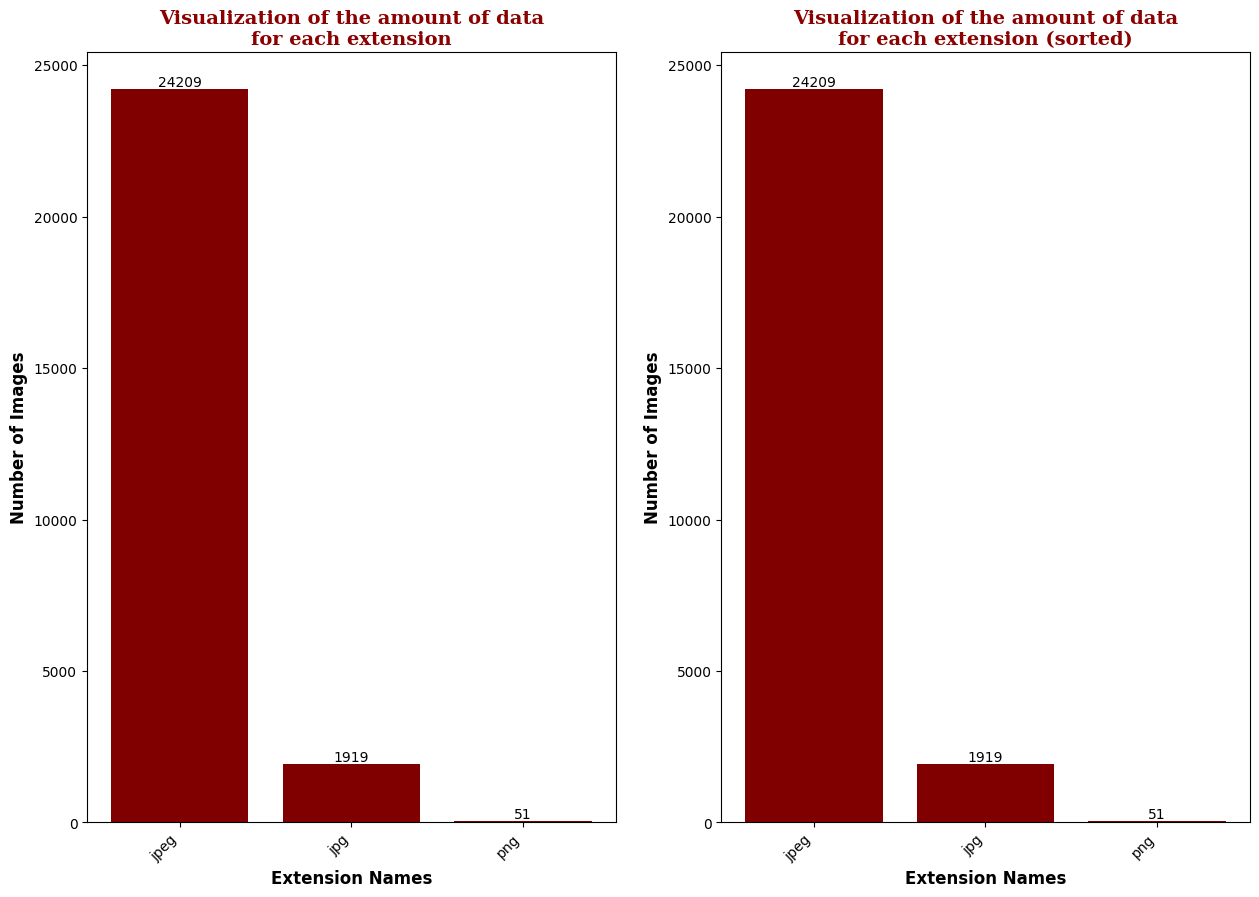

In [ ]:
# visualization of image extensions count
labels = list(number_of_each_ext.keys())
values = list(number_of_each_ext.values())
labels_sorted = list(number_of_each_ext_sorted.keys())
values_sorted = list(number_of_each_ext_sorted.values())

figure, axis = plt.subplots(1, 2, figsize=(15,10))

font_for_title = {
    'family': 'serif',
    'color':  'darkred',
    'weight': 'bold',
    'size': 14,
    }

font_for_labels = {
    'family': 'sans serif',
    'color':  'black',
    'weight': 'bold',
    'size': 12,
    }

bars = axis[0].bar(labels, values, color='maroon')
for bar in bars:
    height = bar.get_height()
    axis[0].text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=10)

axis[0].set_title('Visualization of the amount of data\nfor each extension', fontdict=font_for_title)
axis[0].set_xlabel('Extension Names', fontdict=font_for_labels)
axis[0].set_ylabel('Number of Images', fontdict=font_for_labels)
axis[0].set_xticks(axis[0].get_xticks())
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45, ha='right')

bars = axis[1].bar(labels_sorted, values_sorted, color='maroon')
for bar in bars:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=10)

axis[1].set_title('Visualization of the amount of data\nfor each extension (sorted)', fontdict=font_for_title)
axis[1].set_xlabel('Extension Names', fontdict=font_for_labels)
axis[1].set_ylabel('Number of Images', fontdict=font_for_labels)
axis[1].set_xticks(axis[0].get_xticks())
axis[1].set_xticklabels(axis[0].get_xticklabels(), rotation=45, ha='right')

In [ ]:
# dividing dataset to train and test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size

train_data, test_data = random_split(dataset=data, lengths=[train_size, test_size])
print(f'train: {len(train_data)}, test: {len(test_data)}')

train: 20943, test: 5236


In [ ]:
# getting validation data
valid_size = int(len(train_data) * 0.15)
train_size = len(train_data) - valid_size

train_data, valid_data = random_split(dataset=train_data, lengths=[train_size, valid_size])
print(f'train: {len(train_data)}, test: {len(valid_data)}')

train: 17802, test: 3141


In [ ]:
# adding transform
train_data.dataset.transform = transform
test_data.dataset.transform = transform_test
valid_data.dataset.transform = transform_test

In [ ]:
# creating data loader
batch_size=32
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True)
data_loader

In [ ]:
# creating data loader for test and train data
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# creating data loader for validation data
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False)

In [ ]:
# creating images and labels variables
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}, labels shape: {labels.shape}')

images shape: torch.Size([32, 3, 256, 256]), labels shape: torch.Size([32])


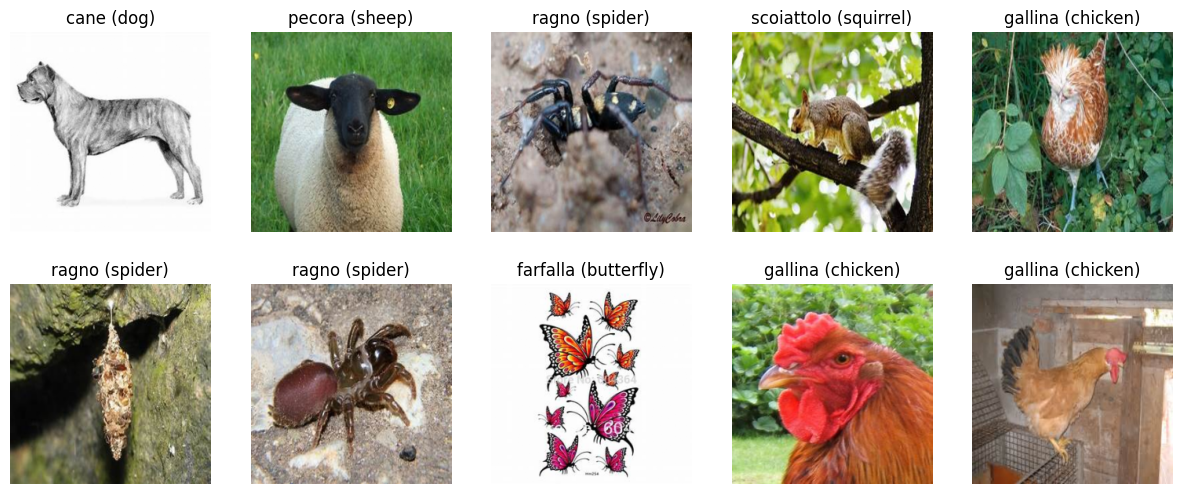

In [ ]:
# visualization of some images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0)
    ax.imshow(img)
    ax.set_title(f'{classes[labels[i]]} ({classes_eng[labels[i]]})')
    ax.axis("off")

plt.show()

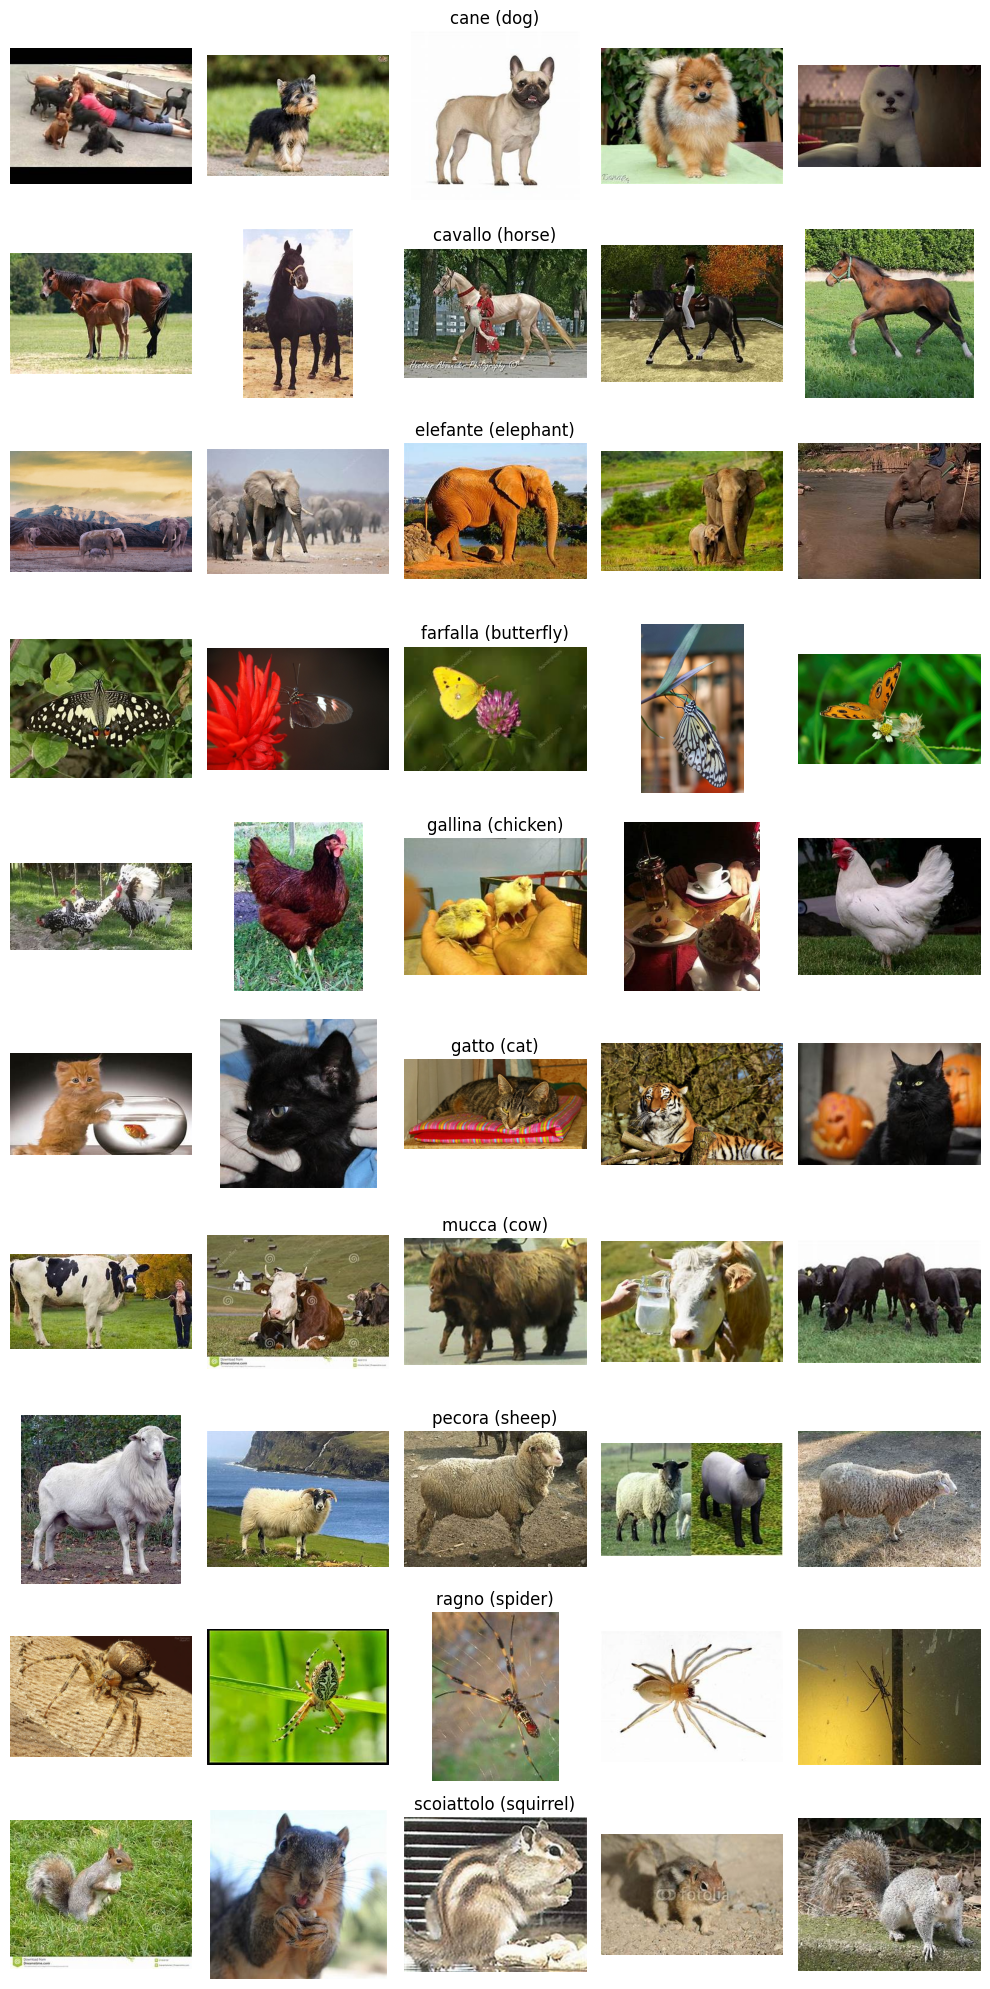

In [ ]:
# visualization of some images by classes
import random
num_of_samples = 5
fig, axes = plt.subplots(len(classes), num_of_samples, figsize=(10, 20))

for i, class_name in enumerate(classes):
    class_dir = os.path.join(path, class_name)
    image_files = os.listdir(class_dir)

    selected_images = random.sample(image_files, min(num_of_samples, len(image_files)))

    for j, img_file in enumerate(selected_images):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path)

        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == num_of_samples//2:
            axes[i, j].set_title(f'{class_name} ({classes_eng[i]})', fontsize=12)

plt.tight_layout()
plt.show()